<a href="https://colab.research.google.com/github/celinagacias/dc-symmetron/blob/main/Data%20Cleaning%20and%20Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import string
import re
import itertools

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

import nltk
from nltk.util import everygrams
nltk.download('stopwords')
from nltk.corpus import stopwords
!pip install stop_words
from stop_words import get_stop_words

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth, drive
from oauth2client.client import GoogleCredentials

pd.set_option('max_rows', None)
pd.set_option('max_colwidth', None)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for stop_words: filename=stop_words-2018.7.23-py3-none-any.whl size=32910 sha256=99b3fcd1863ff897e2c94511c19d5b315580bdc07ec621a732a70904cd04bbdf
  Stored in directory: /root/.cache/pip/wheels/eb/03/0d/3bd31c983789aeb0b4d5e2ca48590288d9db1586cf5f225062
Successfully built stop_words


# Data Read-In

In [2]:
#Authenticate user
auth.authenticate_user()
gauth = GoogleAuth()

#Mount GDrive
gdrive = GoogleDrive(gauth)
gauth.credentials = GoogleCredentials.get_application_default()
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Read data from csv
folder = '1iLA5sSyu7ere1AN40TWRf6O6ma5LoIDl'
filename = 'raw_AACT_data.csv'

gfile_list = gdrive.ListFile({'q': "'" +  folder + "'" + " in parents and trashed=false"}).GetList()
gfile = [f for f in gfile_list if f['title'] == filename][0]
df_file = gdrive.CreateFile({'id': gfile['id']})
df_file.GetContentFile(gfile['title'])
df = pd.read_csv(filename)
display(df.head(2))

,nct_id,start_date,start_date_type,study_type,phase,overall_status,last_known_status,brief_title,population,gender_description,minimum_age,maximum_age,gender,healthy_volunteers,countries_removed,countries_retained,conditions_table,mesh_term,criteria
0,NCT00000113,1997-09-30,NaN,Interventional,Phase 3,Completed,NaN,Correction of Myopia Evaluation Trial (COMET),NaN,NaN,6 Years,12 Years,All,No,{},"{""United States""}",myopia,"eye diseases, myopia, refractive errors","Children between the ages of 6 and 12 years with myopia in both eyes (defined as spherical equivalent between -1.25 D and -4.50 D in each eye as measured by cycloplegic autorefraction), astigmatism less than or equal to 1.50 D, and no anisometropia (defined as a difference in spherical equivalent between the two eyes greater than 1.0 D) are eligible for inclusion. Exclusion criteria include visual acuity greater than 20/25, strabismus, use of contact lenses, birth weight less than 1,250 grams, use of bifocal or progressive addition lenses, or any conditions precluding adherence to the protocol."
1,NCT00000114,1984-05-31,NaN,Interventional,Phase 3,Completed,NaN,Randomized Trial of Vitamin A and Vitamin E Supplementation for Retinitis Pigmentosa,NaN,NaN,18 Years,49 Years,All,NaN,NaN,NaN,retinitis pigmentosa,"eye diseases, retinal diseases, retinitis pigmentosa, retinitis, genetic diseases, inborn, retinal degeneration, retinal dystrophies, eye diseases, hereditary","Men and nonpregnant women between ages 18 and 49 years with common forms of RP were included. All eligible patients had retinal arteriolar attenuation, elevated dark adaptation thresholds, and reduced ERGs. Patients had best corrected Snellen visual acuity of 20/100 or better, central visual field diameter on the Goldman perimeter with V4 e white test light of 8 degrees or greater, and ERG amplitude of 2.5 or greater in response to 0.5-Hz white light or of 0.12 ultraviolet light or greater in response to 30-Hz white flickering light in at least one eye. In addition, patients had normal fasting serum retinol and serum liver function profile and weight above the lower fifth percentile for age, sex, and height. All patients had a total estimated pre-trial intake of vitamins A and E from diet plus pills not greater than 11,500 IU/day and 40 IU/day, respectively."


In [4]:
n = len(df)
print(f'There are {n} studies in our sample.')

There are 42299 studies in our sample.


# Data Cleaning

In [5]:
# list of major cancer categories
cancers = ['digestive system', 'respiratory tract', 'head and neck']
categories = [c + ' neoplasms' for c in cancers]
categories = sorted(categories, key=lambda x: -len(df[df.mesh_term.fillna('').str.contains(x)]))
print(categories)

['digestive system neoplasms', 'respiratory tract neoplasms', 'head and neck neoplasms']


## Dates

In [6]:
# convert start date to date
df['start_date'] = df['start_date'].apply(
    lambda x: datetime.strptime(x, '%Y-%m-%d').date() \
    if str(x) != 'nan' else None)

In [7]:
# extract year into separate column
df['start_year'] = df['start_date'].apply(
    lambda x: int(x.year) if x is not None else None)

## Countries

In [8]:
def process_countries(l):
  # converts string of list of countries into lists
  l = l.replace('{','').replace('}','').split(',')
  l = set([c.replace('"','') for c in l])
  return l

In [9]:
# apply the function to each list of countries
df['countries_removed'] = df['countries_removed'].apply(
    lambda x: process_countries(x) if str(x) != 'nan' else None)

df['countries_retained'] = df['countries_retained'].apply(
    lambda x: process_countries(x) if str(x) != 'nan' else None)

## Ages

In [10]:
def parse_age(a):
  # Convert text of age into years
  if str(a) == 'nan':
    return np.nan

  num = int(str(a).split(' ')[0])
  if 'Year' in a:
    age = num
  elif 'Month' in a:
    age = num / 12
  elif 'Week' in a:
    age = num / 52
  elif 'Day':
    age = num / 365
  elif 'Hour' in a:
    age = num / (24 * 365)
  elif 'Minute' in a:
    age = num / (24 * 365 * 60)
  return age

df['minimum_age'] = df['minimum_age'].apply(parse_age)
df['maximum_age'] = df['maximum_age'].apply(parse_age)

## Inclusion/Exclusion Criteria

In [11]:
# identify which studies have clear inclusion vs. exclusion
df['criteria_norm'] = df.criteria.fillna('').str.upper().str.strip().str.replace(' CRITERIA','')
inc_cond = df.criteria_norm.str.contains('INCLUSION:')
exc_cond = df.criteria_norm.str.contains('EXCLUSION:')
parse_mask = (inc_cond) & (exc_cond)
len_parse = df[parse_mask].shape[0]
print(f'There are {len_parse} ({np.round(len_parse*100/n, 2)}%) studies with clearly delineated inclusion/exclusion criteria')

There are 38232 (90.39%) studies with clearly delineated inclusion/exclusion criteria


In [12]:
def parse_criteria(c):
  '''Splits criteria into inclusion and exclusion'''

  def clean_criteria(s):
    # sub-function to clean up criteria text
    s = s.replace('INCLUSION:','').strip() # remove inclusion title
    s = re.sub(r'(\n\s*)+\n+', '\n', s) # reduce newlines
    return s

  # create list with [inclusion, exclusion]
  c_list = c.split('EXCLUSION:')
  c_list = [clean_criteria(s) for s in c_list]
  return c_list

# apply the function to derive inclusion and exclusion
df['inclusion'] = None
df['exclusion'] = None
df.loc[parse_mask, 'criteria_split'] = df.loc[parse_mask, 'criteria_norm'].apply(parse_criteria)
df.loc[parse_mask, 'inclusion'] = df.loc[parse_mask, 'criteria_split'].apply(lambda x: x[0])
df.loc[parse_mask, 'exclusion'] = df.loc[parse_mask, 'criteria_split'].apply(lambda x: x[1])

## Subsetting

In [13]:
# remove studies that were paused or suspended
suspend_mask = (df.overall_status.isin(['Terminated', 'Withdrawn', 'Suspended']))
n_suspend = df[suspend_mask].shape[0]
print(f'There are {n_suspend} studies that need to be removed because they are either terminated, withdrawn, or suspended.')
df = df[~suspend_mask].copy(deep=True)
print(f'There are {len(df)} studies remaining.')

There are 4600 studies that need to be removed because they are either terminated, withdrawn, or suspended.
There are 37699 studies remaining.


In [14]:
# obtain subset of cancer studies
df = df[(df.mesh_term.str.contains('neoplasm')) | 
        (df.mesh_term.str.contains('carcinoma')) | 
        (df.mesh_term.str.contains('cancer'))].copy(deep=True)
print(f'There are {len(df)} studies for cancer-related interventions.')

There are 7385 studies for cancer-related interventions.


In [15]:
'''additional step: make sure that the categories are exclusive of other 
categories that are not already in our list (Ex: breast)'''

'additional step: make sure that the categories are exclusive of other \ncategories that are not already in our list (Ex: breast)'

In [16]:
# subset to just the studies that fit into just 1 category

# obtain the applicable categories for each study, in a list
df['category'] = df.mesh_term.apply(lambda x: sorted([c for c in categories if c in x]))
df = df[df.category.apply(lambda x: len(x) == 1)].copy(deep=True)
df['category'] = df.category.apply(lambda x: x[0])
print(f'There are {len(df)} studies that fit into just 1 of the categories we identified')

There are 2469 studies that fit into just 1 of the categories we identified


# Initial Analysis

## Basic Descriptives

In [17]:
# most common mesh terms
mesh_list = df.mesh_term.apply(lambda x: x.split(', '))
all_mesh = [t for t in list(itertools.chain.from_iterable(mesh_list)) if \
            any([t.startswith(s) for s in ['neoplasm','cancer','carcinoma']]) is False]
mesh_freq = pd.Series(all_mesh).value_counts()
display(mesh_freq.head(30))

digestive system diseases      1318
digestive system neoplasms     1298
gastrointestinal diseases       863
gastrointestinal neoplasms      842
respiratory tract neoplasms     815
thoracic neoplasms              815
lung neoplasms                  808
respiratory tract diseases      807
lung diseases                   805
bronchogenic                    681
bronchial neoplasms             681
glandular and epithelial        635
intestinal diseases             589
intestinal neoplasms            585
non-small-cell lung             584
colorectal neoplasms            581
rectal diseases                 482
colonic diseases                460
head and neck neoplasms         356
adenocarcinoma                  350
liver diseases                  290
liver neoplasms                 289
hepatocellular                  230
stomach diseases                227
stomach neoplasms               225
endocrine system diseases       210
endocrine gland neoplasms       209
pathologic processes        

In [18]:
# no. of studies per set of categories
print('no. of studies per category or set of categories')
all_cat_count = df.category.value_counts()
all_cat_prop = all_cat_count / len(df)
display(all_cat_count)
print('proportion:')
display(all_cat_prop)

no. of studies per category or set of categories


digestive system neoplasms     1298
respiratory tract neoplasms     815
head and neck neoplasms         356
Name: category, dtype: int64

proportion:


digestive system neoplasms     0.525719
respiratory tract neoplasms    0.330093
head and neck neoplasms        0.144188
Name: category, dtype: float64

## By Age

Perform analysis of excluded age groups

In [19]:
def get_ages(min, max):
  # generate list of excluded ages, given minimum and maximum
  reference_ages = set( range(0, 101) )

  if str(min) != 'nan' and str(max) != 'nan':
    inc = set( range( int(min), int(max)+1 ) )
  elif str(min) == 'nan' and str(max) != 'nan':
    inc = set( range(0, int(max)+1 ) )
  elif str(min) != 'nan' and str(max) == 'nan':
    inc = set( range( int(min), 101) )
  else:
    inc = reference_ages

  exc = sorted(list(reference_ages - inc))
  return exc

df['excluded_ages'] = df.apply(lambda x: get_ages(x.minimum_age, x.maximum_age), axis=1) 

display( df[['minimum_age', 'maximum_age', 'excluded_ages']].head() )

,minimum_age,maximum_age,excluded_ages
203,50.0,79.0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]"
354,20.0,80.0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]"
360,18.0,NaN,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]"
365,18.0,NaN,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]"
368,20.0,80.0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]"


There are 1298 clinical trials for digestive system neoplasms.
There are 815 clinical trials for respiratory tract neoplasms.
There are 356 clinical trials for head and neck neoplasms.


(array([  0.5,   5.5,  10.5,  15.5,  20.5,  25.5,  30.5,  35.5,  40.5,
         45.5,  50.5,  55.5,  60.5,  65.5,  70.5,  75.5,  80.5,  85.5,
         90.5,  95.5, 100.5]), <a list of 21 Text major ticklabel objects>)

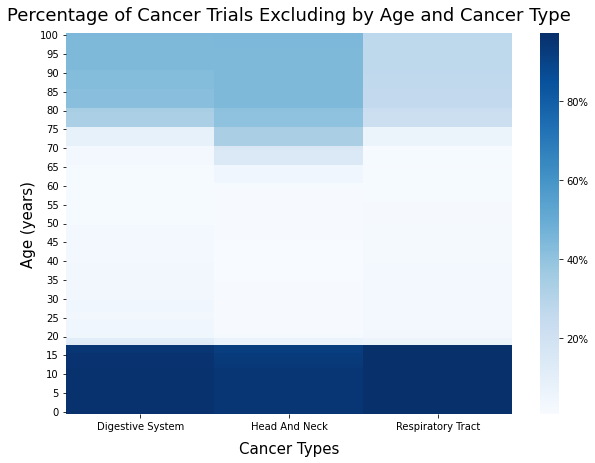

In [20]:
# obtain subset of cancer studies

# for obtaining the "exclusion rate" per age from 0-100 based on a search term
def count_age_exclude(search_term, df=df):

  def count_trials(sub, age):
    where_excluded = sub[sub.excluded_ages.apply(lambda x: age in x)]
    no_excluded = len(where_excluded)
    return no_excluded

  sub = df[df.mesh_term.str.contains(search_term)].copy(deep=True)
  n = len(sub)
  print(f'There are {n} clinical trials for {search_term}.')
  ages = list( range(0,101) )
  percent_trials = [count_trials(sub, age)/n for age in ages]
  result = pd.DataFrame({
    'age': ages,
    'sub_type': [search_term] * len(ages),
    'percent_trials': percent_trials
  })
  return result

# for obtaining the same thing for multiple search terms
tables = [count_age_exclude(term) for term in categories]
lt = pd.concat(tables)
lt['percent_trials'] = lt['percent_trials'].apply(lambda x: x*100)

# pivot from long to wide
lt_wide = pd.pivot(lt, index='age', columns = 'sub_type', values = 'percent_trials')
lt_wide.sort_values('age', ascending=False, inplace=True)
lt_wide.columns = lt_wide.columns.str.replace(' neoplasms','').str.title()

# generate heat map
plt.figure(figsize=(10, 7))
sns.heatmap(lt_wide, yticklabels=5, cmap="Blues", cbar_kws={'format': '%.0f%%'})
plt.title('Percentage of Cancer Trials Excluding by Age and Cancer Type', pad=13, fontsize=18)
plt.xlabel("Cancer Types", labelpad=10, fontsize=15)
plt.xticks(rotation=0)
plt.ylabel("Age (years)", fontsize=15)
plt.yticks(rotation=0)

## By Gender

Gender proportions across all studies and by cancer type: 

In [21]:
df['excludes_females'] = df['gender'].apply(lambda x: x == "Male")
df['excludes_males'] = df['gender'].apply(lambda x: x == "Female")

# create new dataframe to store sex exclusion data
sex_exclusion_df = pd.DataFrame(data = list(df.category.unique()), columns = ["category"])

# populate the dataframe with the proportion of trials in each category excluding males/females
# reset_index() allows the columns of the rightside 'groupby-generated' df (which has multilevel indexing) to be combined with sex_exclusion_df
sex_exclusion_df[['excludes_males', 'excludes_females']] = df.groupby(['category'])[['excludes_males', 'excludes_females']].mean().reset_index(level=0, drop=True)

# add in marginal exclusion by sex across all cancer categories 
sex_exclusion_df = sex_exclusion_df.append(
    pd.DataFrame({'category': ['Across All Studies'], 
     'excludes_males': [df.excludes_males.mean()], 
     'excludes_females': [df.excludes_females.mean()]}))

display(sex_exclusion_df)


,category,excludes_males,excludes_females
0,digestive system neoplasms,0.025424,0.001541
1,head and neck neoplasms,0.002809,0.008427
2,respiratory tract neoplasms,0.001227,0.000000
0,Across All Studies,0.014176,0.002025


## Exclusion Criteria

In [22]:
# summarize no. of studies with separable criteria
crit_mask = (df.inclusion.notnull()) & (df.exclusion.notnull())
with_crit = crit_mask.value_counts()
print(f'''No. of studies with distinct inclusion and exclusion criteria: 
{with_crit}''')

print('By category:')
for c in categories:
  print(c)
  sub = df[df.category == c].copy(deep=True)
  print( (sub.inclusion.notnull() & sub.exclusion.notnull()).value_counts() )

No. of studies with distinct inclusion and exclusion criteria: 
True     2057
False     412
dtype: int64
By category:
digestive system neoplasms
True     1089
False     209
dtype: int64
respiratory tract neoplasms
True     670
False    145
dtype: int64
head and neck neoplasms
True     298
False     58
dtype: int64


In [23]:
# remove punctuation and stopwords

# list down stopwords

stop_words = list(get_stop_words('en'))
nltk_words = list(stopwords.words('english')) 
stop_words.extend(nltk_words)
stop_words = [s.translate(str.maketrans('', '', string.punctuation)) for s in stop_words]

clean_string = lambda x: ' '.join([w for w in x.translate(str.maketrans('', '', string.punctuation)).split() \
                                   if w.lower() not in stop_words and w.isdigit() is False]) \
                                   if x is not None else None

df['exclusion_clean'] = df['exclusion'].apply(clean_string).fillna('')

In [24]:
# view common n-grams (length of 2 to 4)
to_ngram = lambda x: set(everygrams(x.split(), min_len=2, max_len=5)) if x != '' else None
ngrams = df.exclusion_clean.apply(to_ngram)
all_ngrams = list(itertools.chain.from_iterable([s for s in ngrams if s is not None]))
ngram_count = pd.Series(all_ngrams).value_counts()
display( ngram_count.head(100) )

(WITHIN, DAYS)                           510
(MYOCARDIAL, INFARCTION)                 493
(HEART, FAILURE)                         474
(WITHIN, WEEKS)                          471
(WITHIN, MONTHS)                         406
(CELL, CARCINOMA)                        382
(CONGESTIVE, HEART)                      379
(CONGESTIVE, HEART, FAILURE)             372
(BASAL, CELL)                            349
(CARCINOMA, SITU)                        346
(HEPATITIS, B)                           345
(DAYS, PRIOR)                            344
(SKIN, CANCER)                           337
(CENTRAL, NERVOUS)                       329
(NERVOUS, SYSTEM)                        327
(CENTRAL, NERVOUS, SYSTEM)               321
(CLINICALLY, SIGNIFICANT)                318
(WEEKS, PRIOR)                           317
(ACTIVE, INFECTION)                      315
(UNSTABLE, ANGINA)                       314
(PREGNANT, LACTATING)                    305
(WITHIN, DAYS, PRIOR)                    294
(HUMAN, IM

In [25]:
## keyword library
keywords = {
    'heart_issues': [
        'CONGESTIVE HEART','HEART FAILURE','ANGINA','ISCHEMIC HEART',
        'CORONARY DISEASE','CORONARY ARTERY DISEASE', 'HYPERTENSION','MYOCARDIAL',
        'CARDIAC','CARDIOVASC','ARRHYTHMIA','ARRYTHMIA','HIGH BLOOD PRESSURE'
        ],
    'hiv': [
        'HIV-','-HIV',',HIV','HIV/AIDS','(HIV)','KNOWN HIV',
        'PROVEN HIV','HIV POSITIV','HIV-POSITIV','HUMAN IMMUNODEFICIENCY',
        'OR HIV','HIV INFECT','HIV-INFECT',' HIV'
        ],
    'pregnant': ['PREGNAN'],
    'breastfeeding': ['LACTATING','LACTATION','BREAST FEED','BREAST-FEED', 'BREAST- FEED','BREASTFEED'],
    'psychosis': [
        'PSYCH', 'DEPRESSI', 'ANXIETY', 'SCHIZOPHRENI', 'MENTAL ILLNESS', 
        'MENTAL DISORDER'
        ]
}

,exclusion_criteria,no_trials,total_trials,percent_trials
2,pregnant,1201,2469,48.643175
0,heart_issues,1043,2469,42.243823
3,breastfeeding,1004,2469,40.664237
4,psychosis,594,2469,24.058323
1,hiv,536,2469,21.709194


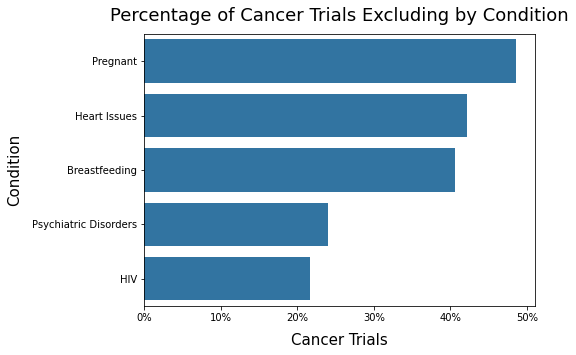

In [26]:
exclusion_dfs = []

for key in keywords.keys():
  search_terms = keywords[key]
  terms_col = f'{key}_terms'
  df[terms_col] = df.exclusion.apply(lambda x: [term for term in search_terms if term in x] \
                                     if x is not None else [])
  df[key] = df[terms_col].apply(lambda x: len(x) > 0)

  # summarize the % of studies per category
  for c in categories:
    cat_mask = (df.category.apply(lambda x: c in x))
    exclusion_sub = {
        'exclusion_criteria': key,
        'cancer_category': c,
        'no_trials': len(df[df[key] & cat_mask]),
        'total_trials': len(df[cat_mask]),
        'percent_trials': len(df[df[key] & cat_mask])*100 / len(df[cat_mask])
    }
    exclusion_dfs.append(exclusion_sub)

# create top-level summary of exclusion criteria present
exc_top = df[list(keywords.keys())].agg(['sum','mean']).transpose().reset_index()
exc_top.rename(columns = {'index': 'exclusion_criteria', 
                          'sum': 'no_trials',
                          'mean': 'percent_trials'}, inplace=True)
exc_top['no_trials'] = exc_top['no_trials'].astype(int)
exc_top['total_trials'] = len(df)
exc_top['percent_trials'] = exc_top['percent_trials'] * 100
exc_top = exc_top[['exclusion_criteria', 'no_trials', 'total_trials', 'percent_trials']]
exc_top.sort_values('no_trials', ascending=False, inplace=True)
display(exc_top)

# plot the top-level summary
criteria_map = {
    'pregnant': 'Pregnant',
    'heart_issues': 'Heart Issues',
    'breastfeeding': 'Breastfeeding',
    'psychosis': 'Psychiatric Disorders',
    'hiv': 'HIV'
}

exc_top['exclusion_criteria'] = exc_top['exclusion_criteria'].map(criteria_map)
plt.figure(figsize=(7, 5))
ax = sns.barplot(data=exc_top, x='percent_trials', y='exclusion_criteria',
            color='tab:blue')
ax.set_title('Percentage of Cancer Trials Excluding by Condition', pad=13, fontsize=18)
ax.set_xlabel('Cancer Trials', labelpad=10, fontsize = 15)
ax.set_ylabel('Condition', labelpad=10, fontsize = 15)
ax.xaxis.set_major_formatter(mtick.PercentFormatter())
plt.show()

# collect per-criteria summaries into one table
exc_summary = pd.DataFrame(exclusion_dfs).sort_values(['cancer_category','exclusion_criteria'])

no_trials
cancer_category             exclusion_criteria           
digestive system neoplasms  heart_issues              585
                            hiv                       251
                            pregnant                  672
                            breastfeeding             548
                            psychosis                 329
head and neck neoplasms     heart_issues              122
                            hiv                        63
                            pregnant                  190
                            breastfeeding             162
                            psychosis                  85
respiratory tract neoplasms heart_issues              336
                            hiv                       222
                            pregnant                  339
                            breastfeeding             294
                            psychosis                 180

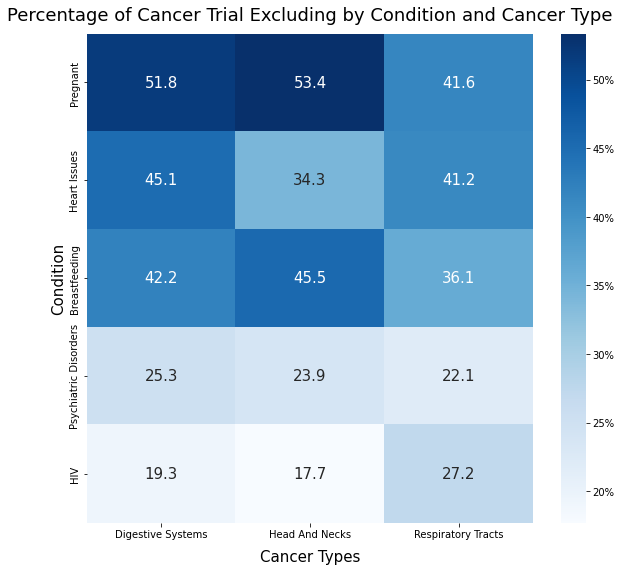

In [27]:
## generate heatmap

# sort exclusion criteria by no. of studies affected
order = sorted(keywords.keys(), key=lambda x: len(df[x]), reverse=True)
exc_summary['exclusion_criteria'] = pd.Categorical(exc_summary['exclusion_criteria'], order)
exc_wide = pd.pivot(exc_summary[['exclusion_criteria','cancer_category','percent_trials']].copy(deep=True), 
                    index='exclusion_criteria', 
                    columns = 'cancer_category', 
                    values = 'percent_trials')

# display the no. of trials by cancer category and exclusion criteria
exc_count = exc_summary.groupby(['cancer_category','exclusion_criteria']).no_trials.sum().to_frame()
display(exc_count)

# plot the wide-format table
exc_wide.columns = exc_wide.columns.str.replace(' neoplasm','').str.strip().str.title()
exc_wide.index = exc_wide.index.values.map(criteria_map)
exc_wide.sort_values('Digestive Systems', ascending=False, inplace=True)
plt.figure(figsize=(10,9))
ax = sns.heatmap(exc_wide, cmap="Blues", annot=True, annot_kws={"size": 15}, fmt = '.1f', cbar_kws={'format': '%.0f%%'})
ax.patch.set_facecolor('xkcd:white')
ax.set_title('Percentage of Cancer Trial Excluding by Condition and Cancer Type', pad=13, fontsize=18)
ax.set_ylabel('Condition', fontsize = 15)
ax.set_xlabel('Cancer Types', labelpad=10, fontsize=15)
plt.xticks(rotation=0)
plt.show()

# Time Trends

Create New dataframe for Studies without Start Year, Report initial summary statistics 

Original number of studies: 2469
Number of studies with recorded start year: 2469
Earliest start year: 1971
Lastest start year: 2023


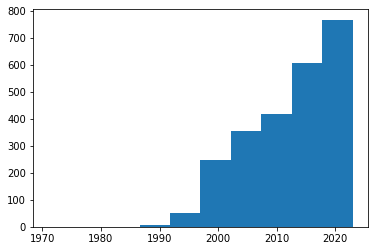

Earliest start year allowed: 2008
Number of studies after and including 2008: 1794


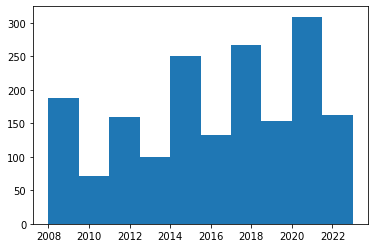

In [28]:
time_trend_df = df.copy()
print(f'Original number of studies: {len(time_trend_df)}')

# get rid of rows(i.e., studies) that do not have a start year and therefore do not fall into a year bin.
# this is important to do since we are looking at time trend data.
# I need to change this to a mask ...
time_trend_df = time_trend_df[time_trend_df.start_year != "None"]
print(f'Number of studies with recorded start year: {len(time_trend_df)}')

# ror all studies with start years: min and max start year, histogram of start years 
print(f'Earliest start year: {int(time_trend_df["start_year"].min())}')
print(f'Lastest start year: {int(time_trend_df["start_year"].max())}')
fig = plt.hist(time_trend_df["start_year"])
plt.show()

# remove all studies before a given year
earliest_start_year_allowed = 2008
time_trend_df = time_trend_df[time_trend_df.start_year >= earliest_start_year_allowed]
print(f'Earliest start year allowed: {earliest_start_year_allowed}')
print(f'Number of studies after and including {earliest_start_year_allowed}: {len(time_trend_df)}')
fig = plt.hist(time_trend_df["start_year"])
plt.show()

Create Year Group Category Column

In [29]:
# set breaks for year bins.
year_bin_cutpoints = pd.array([earliest_start_year_allowed, 2012, 2016, 2020, 2024], dtype = np.ndarray)
# use breaks to create an IntervalIndex object. Intervals include left-side (lower) limit.
year_bin_intervals = pd.IntervalIndex.from_breaks(breaks = year_bin_cutpoints, closed = 'left')

# create a new column which places studies into categories according to the year bins made above
time_trend_df['year_bin'] = pd.cut(x = time_trend_df['start_year'], bins = year_bin_intervals)

# visual inspection of the newly created column
display(time_trend_df[['start_year', 'year_bin']].head())

,start_year,year_bin
10022,2008.0,"[2008, 2012)"
10221,2008.0,"[2008, 2012)"
10406,2008.0,"[2008, 2012)"
10423,2008.0,"[2008, 2012)"
10433,2008.0,"[2008, 2012)"


Create Age Bin Boolean Columns

In [30]:
# specify cutpoints for the age bins in age_bin_cutpoints as an array.
age_bin_cutpoints = pd.array([0, 5, 18, 40, 65, 75, 101], dtype = np.ndarray)

# use the array to create age bin intervals, which include their left side (lower) limit.
# the intervals are an "IntervalIndex" object
age_bin_intervals = pd.IntervalIndex.from_breaks(breaks = age_bin_cutpoints, closed = 'left')


# given a list of excluded ages and an IntervalIndex interval, determine whether the list of excluded ages ...
# ... caries values that are in the age bin interval.
def check_age_bin(excluded_ages, age_bin_interval):
  # turn the excluded age list into a set
  excluded_ages_set = set(excluded_ages)
  # create a set with all integers in the age_bin_interval
  age_bin_set = set(range(age_bin_interval.left, age_bin_interval.right))
  #if the two sets have a non-empty intersection, return true, otherwise return false.
  if not excluded_ages_set.intersection(age_bin_set):
    return False
  else:
    return True

# drops any existing age_bin_ boolean columns.
# this is to prevent keeping old age bin columns after new age bins have been set.
time_trend_df = time_trend_df[time_trend_df.columns.drop(list(time_trend_df.filter(regex='age_bin_')))]


# create age bin boolean columns for every age bin.
for age_bin_interval in age_bin_intervals:
  # names every boolean column created "age_bin_lowerlim_upperlim"
  # applies the check_age_bin function above to create the boolean column
  time_trend_df[f'age_bin_{age_bin_interval.left}_{age_bin_interval.right}'] = time_trend_df.apply(lambda x: check_age_bin(x.excluded_ages, age_bin_interval), axis=1)


# store the age bin columns in a list.
age_bin_columns = [col for col in time_trend_df if col.startswith('age_bin')]
# display the excluded ages and all age_bin_columns for quick visual inspection.
display(time_trend_df[['excluded_ages'] + age_bin_columns].head(3))

,excluded_ages,age_bin_0_5,age_bin_5_18,age_bin_18_40,age_bin_40_65,age_bin_65_75,age_bin_75_101
10022,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]",True,True,False,False,False,False
10221,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]",True,True,False,False,False,False
10406,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]",True,True,True,False,False,True


In [39]:
# list of all age bin/keyword boolean columns
exclusion_list = age_bin_columns + list(keywords.keys()) # creates a list of all exclusion criteria keywords

# creates a new dataframe to store the plot data with two columns.
# these columns show every unique combination of study category and year_bin in the study data.
plot_time = pd.DataFrame(data = list(itertools.product(time_trend_df.category.unique(), time_trend_df.year_bin.unique())), columns = ["category", "year_bin"])

# display the number of studies in each category/age_bin group
display(time_trend_df.groupby(['category', 'year_bin'])['year_bin'].count())

# place all of proportions of trials excluding a given condition in each cancer group into a common data frame
for condition in exclusion_list:
   # calculates the proportion of trials with that exclusion criteria in each category/year-bin group.
   # reset index (to standard integers, instead of multilevel index from groupby)
   # this allows the series to be added on as a column to a common data frame.
  new_col = time_trend_df.groupby(['category', 'year_bin'])[condition].mean().reset_index(level=0, drop=True) # .mean() takes the mean of the boolean values in the groups, interpreting true as 1 and false as 0.
  plot_time[condition] = new_col.reset_index(level=0, drop=True)

category                     year_bin    
digestive system neoplasms   [2008, 2012)    192
                             [2012, 2016)    228
                             [2016, 2020)    287
                             [2020, 2024)    225
head and neck neoplasms      [2008, 2012)     46
                             [2012, 2016)     69
                             [2016, 2020)     72
                             [2020, 2024)     77
respiratory tract neoplasms  [2008, 2012)    103
                             [2012, 2016)    131
                             [2016, 2020)    194
                             [2020, 2024)    170
Name: year_bin, dtype: int64

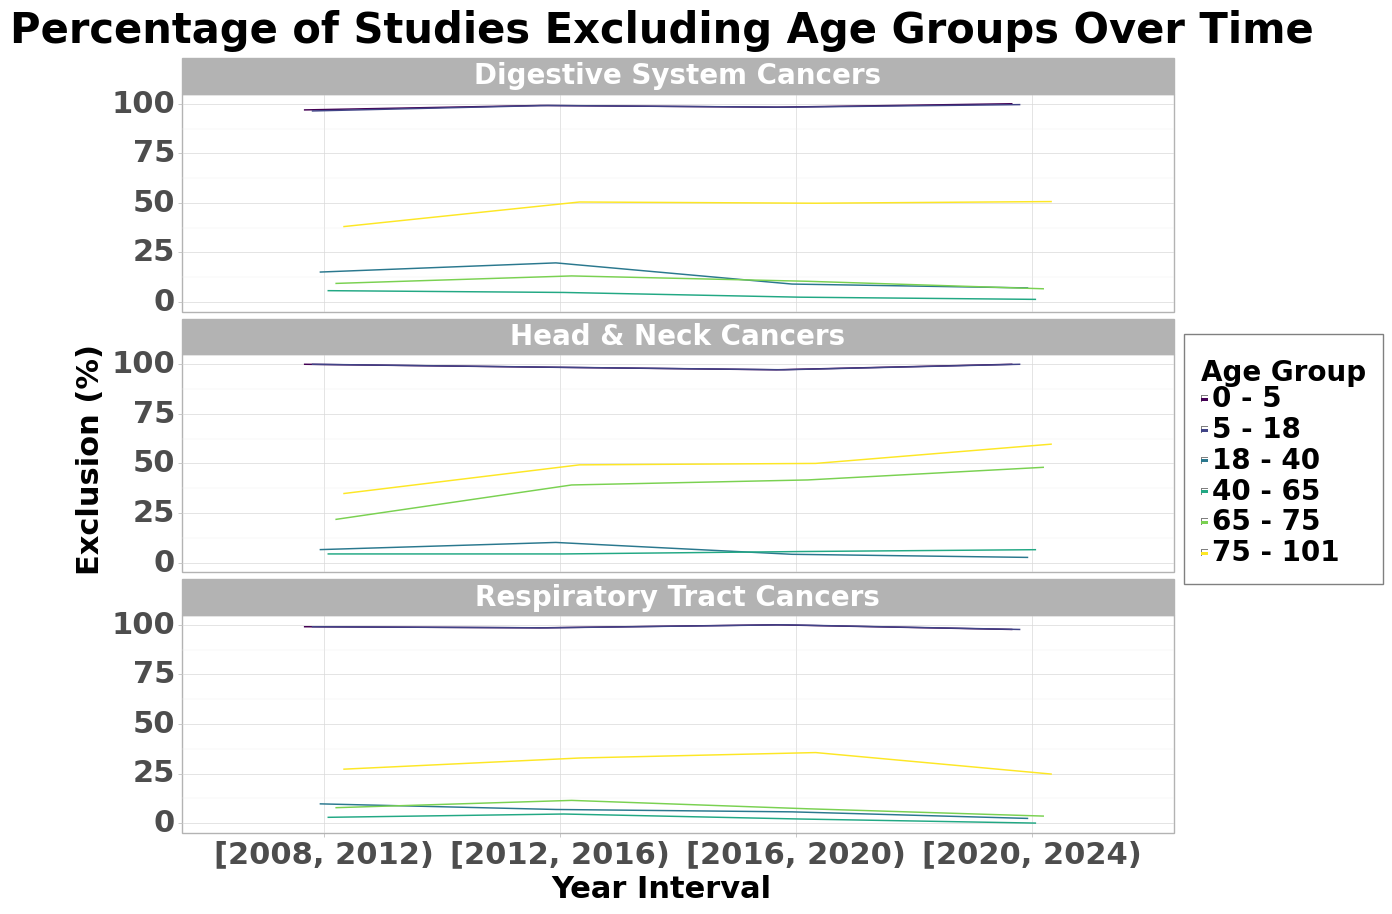

<ggplot: (8763021214949)>

In [107]:
## Create the time trend visualizations
import plotnine as p9

#creating seperate dataframes for age and comorbidities 
age_plot = plot_time.iloc[:, 0:8]
comor_plot = plot_time.drop(plot_time.columns[2:8],axis = 1)

# pivot the tables
age_long = pd.melt(age_plot, id_vars=['category','year_bin'])
age_long.rename(columns={'variable': 'Age Group', 'value': 'Exclusion(%)'}, inplace=True)

comor_long = pd.melt(comor_plot, id_vars=['category','year_bin'])
comor_long.rename(columns={'variable': 'Condition', 'value': 'Exclusion(%)'}, inplace=True)

# change to percentage
age_long['Exclusion(%)'] = age_long['Exclusion(%)']*100
comor_long['Exclusion(%)'] = comor_long['Exclusion(%)']*100

# recode the variables
age_map = {
    'age_bin_0_5': '0 - 5',
    'age_bin_5_18': '5 - 18',
    'age_bin_18_40': '18 - 40',
    'age_bin_40_65': '40 - 65',
    'age_bin_65_75': '65 - 75',
    'age_bin_75_101': '75 - 101'
}

comor_map = {
    'hiv': 'HIV',
    'pregnant': 'Pregnant',
    'breastfeeding': 'Breastfeeding',
    'psychosis': 'Psychiatric Disorders',
    'heart_issues': 'Heart Issues'
}

cat_map = {
    'digestive system neoplasms': 'Digestive System Cancers',
    'head and neck neoplasms': 'Head & Neck Cancers',
    'respiratory tract neoplasms': 'Respiratory Tract Cancers'
}

age_long['Age Group'] = age_long['Age Group'].map(age_map)
age_long['category'] = age_long['category'].map(cat_map)
comor_long['Condition'] = comor_long['Condition'].map(comor_map) 
comor_long['category'] = comor_long['category'].map(cat_map)

# order the age groups so they're correctly ordered on our plots
age_long['Age Group'] = pd.Categorical(age_long['Age Group']).set_categories(
    ["0 - 5", "5 - 18", "18 - 40", "40 - 65", "65 - 75", "75 - 101"], ordered=True)
age_long.sort_values('Age Group', inplace=True)


## create the plots using ggplot
from plotnine import *

# age time trend
(
ggplot(data=age_long)
+ aes(x='year_bin', y='Exclusion(%)', group='Age Group', color='Age Group') 
+ geom_line(position = position_dodge(width= 0.2), size= 0.6) 
+ facet_wrap(facets='~ category', nrow= 3) 
+ ggtitle( "Percentage of Studies Excluding Age Groups Over Time") 
+ theme_light() 
+ theme(plot_title = element_text(size = 30, face = "bold"), 
        axis_text= element_text(size= 22, face= "bold"),
        axis_title = element_text(size= 22, face= "bold"),
        strip_text = element_text(size= 20, face= "bold"),
        legend_key_size = 5,
        legend_text = element_text(size= 20, face= "bold"),
        legend_title = element_text(size= 20, face= "bold"),
        legend_background = element_rect(linetype = 'solid', colour = 'grey'),
        figure_size = (6.4*2, 4.8*2)) 
# + scale_colour_brewer(palette="Dark2") 
+ xlab("Year Interval") 
+ ylab("Exclusion (%)")
)

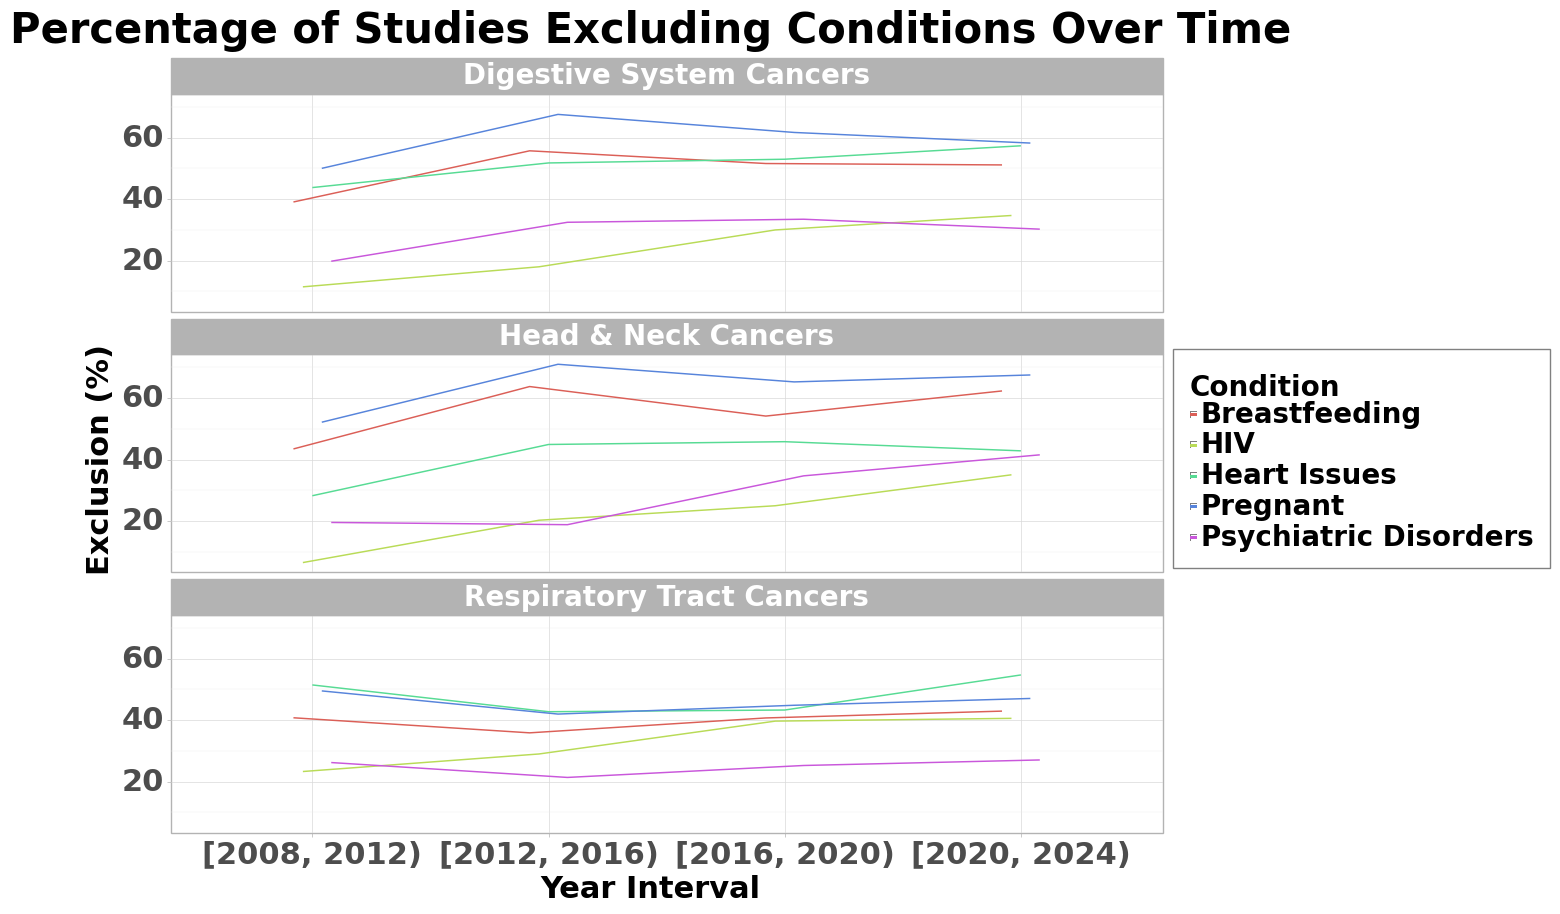

<ggplot: (8763021308992)>

In [108]:
# comorbidities time trend
(
ggplot(data=comor_long)
+ aes(x='year_bin', y='Exclusion(%)', group='Condition', color='Condition') 
+ geom_line(position = position_dodge(width= 0.2), size= 0.6) 
+ facet_wrap(facets='~ category', nrow= 3) 
+ ggtitle( "Percentage of Studies Excluding Conditions Over Time") 
+ theme_light() 
+ theme(plot_title = element_text(size = 30, face = "bold"), 
        axis_text= element_text(size= 22, face= "bold"),
        axis_title = element_text(size= 22, face= "bold"),
        strip_text = element_text(size= 20, face= "bold"),
        legend_key_size = 5,
        legend_text = element_text(size= 20, face= "bold"),
        legend_title = element_text(size= 20, face= "bold"),
        legend_background = element_rect(linetype = 'solid', colour = 'grey'),
        figure_size = (6.4*2, 4.8*2)) 
# + scale_colour_brewer(palette="Dark2") 
+ xlab("Year Interval") 
+ ylab("Exclusion (%)")
)

# Validation of Keyword Search

In [33]:
# packages and authorization to deal with google sheets
import gspread
from gspread_dataframe import set_with_dataframe
from google.auth import default

creds, _ = default()
gs = gspread.authorize(creds)
url = 'https://docs.google.com/spreadsheets/d/1KUIJLbghBD2WUMIkTJ041x92egP5LEwZB-OAw13vCps/'
eval_sheet = gs.open_by_url(url)
members = ['CELINA','CYNTHIA','IDIL','MO','OLIVER']

## Generate Files per Member

In [34]:
# # Uncomment to redo the manual validation
# take 10% of the studies tagged for each keyword
frac = 0.1
all_tagged = []
keys = list(keywords.keys())
for key in keys:
  sub = df[df[key]][['nct_id','exclusion'] + keys].copy(deep=True)
  sam_size = int(np.round(len(sub) * frac))
  all_tagged.append(sub.sample(n=sam_size))
  print(f'{key}: {sam_size} studies')

# place all 10% samples together across all keywords and deduplicate
for_review = pd.concat(all_tagged)
for_review.drop_duplicates(inplace=True)

# add in the studies that were not tagged as any
untagged_mask = (df.apply(lambda x: any([x[k] for k in keys]) is False, axis=1)) & (df.exclusion.notnull())
sam_untag = int(np.round(len(df[untagged_mask]) * frac))
for_review_untagged = df[untagged_mask].sample(n=sam_untag)

# summarize the no. of studies gathered
total_samples = int(np.round(pd.concat([for_review, for_review_untagged]).nct_id.nunique()))
print('')
print(f'{frac} of the studies per tag, placed all together, is n={len(for_review)}')
print(f'There will be {total_samples/5} to review per person')

# create samples for each person

def split(a, n):
  # split an interval into even parts
  k, m = divmod(len(a), n)
  return (a[i*k+min(i, m):(i+1)*k+min(i+1, m)] for i in range(n))

# split the no. indices by 5
inter = list(split(range(len(for_review)), 5))
inter_untagged = list(split(range(len(for_review_untagged)), 5))

# upload to google drive

splits = []

for i in range(0, 5):
  # open the sheet dedicated to the member
  member = members[i]
  member_sheet = eval_sheet.worksheet(member)

  # create the split of the studies for review for that member
  tagged = for_review.iloc[inter[i]].copy(deep=True)
  untagged = for_review_untagged.iloc[inter_untagged[i]].copy(deep=True)
  split = pd.concat([tagged, untagged])
  split = split[['nct_id', 'exclusion','heart_issues', 'hiv', 'pregnant', 
                 'breastfeeding', 'psychosis']]
  splits.append(split)

  # # paste onto the gsheet
  # set_with_dataframe(member_sheet, split, row=2, col=1, 
  #                    include_index=False, include_column_header=False)

# confirm that there are no studies repeating across the splits
if np.sum([len(d) for d in splits]) != pd.concat(splits).nct_id.nunique():
  print('ERROR: There are studies are repeating across the splits.')

heart_issues: 104 studies
hiv: 54 studies
pregnant: 120 studies
breastfeeding: 100 studies
psychosis: 59 studies

0.1 of the studies per tag, placed all together, is n=388
There will be 86.6 to review per person


## Interpret Results

In [35]:
# # interpreting the results

eval_results = []
conditions = ['heart_issues','hiv','pregnant','breastfeeding','psychosis']
colnames = ['nct_id','exclusion'] + conditions

# loop through each member's set of checked clinical trials and place them into one dataframe
for member in members:
  eval_result = pd.DataFrame(eval_sheet.worksheet(member).get_all_values()).iloc[1:, 0:len(colnames)]
  eval_result.columns = colnames
  eval_results.append(eval_result)
  
eval = pd.concat(eval_results)
for c in conditions:
  eval[c] = eval[c].apply(lambda x: True if x == 'TRUE' else False)
eval.rename(columns = {k: f'{k}_real' for k in conditions}, inplace=True)
del eval['exclusion']

# compare with the original dataframe
compare = df[(df.nct_id.isin(set(eval.nct_id)))][colnames].copy(deep=True)
del compare['exclusion']
result = eval.join(compare.set_index('nct_id'), how='left', on='nct_id')

In [36]:
# obtain the scores

import sklearn

scores = []

for c in conditions:
  conf = sklearn.metrics.confusion_matrix(result[f'{c}_real'], result[c])
  tagged = len(result[(result[f'{c}_real']) & (result[c] == result[f'{c}_real'])])
  num = len(result[result[c] == result[f'{c}_real']])
  denom = len(result)
  sens = conf[0][0] / (conf[0][0] + conf[0][1])
  spec = conf[1,1] / (conf[1,1] + conf[1,0])
  acc = num / denom
  misclass = 1 - acc

  score = {
    'condition': c,
    'num_tagged': tagged,
    'num_correct': num,
    'num_all': denom,
    'accuracy': acc,
    'misclass': misclass
  }
  scores.append(score)

scores = pd.DataFrame(scores)
scores['condition'] = scores['condition'].map(criteria_map)
scores.sort_values('condition', inplace=True)
display(scores)

,condition,num_tagged,num_correct,num_all,accuracy,misclass
3,Breastfeeding,261,390,409,0.953545,0.046455
1,HIV,156,405,409,0.990220,0.009780
0,Heart Issues,256,387,409,0.946210,0.053790
2,Pregnant,305,408,409,0.997555,0.002445
4,Psychiatric Disorders,158,393,409,0.960880,0.039120
